In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import numpy as np
import json
from matplotlib.colors import to_hex
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from collections import defaultdict
from typing import Dict
from adjustText import adjust_text
import matplotlib.patheffects as patheffects

# Preprocess the main results table

In [2]:
# Load predefined colormappings
with open("dataset_colors.json", "r") as f:
    dataset_cmap = json.load(f)
with open("method_colors.json", "r") as f:
    method_cmap = json.load(f)

# read through the results on each dataset
base_path = "results"
output_path = 'figure_plots'
datasets = ["cHL_2_MIBI", "IMMUcan"]

In [3]:
results = []
for dataset in datasets:
    df = pd.read_csv(os.path.join(base_path, dataset, "final_results.csv"), sep=";")
    df["dataset"] = dataset
    results.append(df)

results = pd.concat(results, ignore_index=True)

# calculate overall scores
metrics_for_l3 = [
    "f1_weighted_mean", "hierarchical_f1_mean", "macro_f1_mean",
    "mcc_mean", "ari_mean", "jsd_scaled_mean"
]

metrics_for_l1_l2 = [
    "f1_weighted_mean", "macro_f1_mean", "mcc_mean",
    "ari_mean", "jsd_scaled_mean"
]

mask_l3 = results['level'] == 'level_3'
mask_l1_l2 = results['level'].isin(['level_1', 'level_2'])

results.loc[mask_l3, 'weighted_score'] = results.loc[mask_l3, metrics_for_l3].mean(axis=1)
results.loc[mask_l1_l2, 'weighted_score'] = results.loc[mask_l1_l2, metrics_for_l1_l2].mean(axis=1)

# Get the scalability metrics

# qc train_time_mean 
# if train_time_mean is equal to inference_time_mean, set train_time_mean to 0
results["train_time_mean"] = results["train_time_mean"].fillna(0)
results["train_time_mean"] = np.where(results["train_time_mean"] == results["inference_time_mean"], 0, results["train_time_mean"]) 
results["run_time"] = results["train_time_mean"] + results["inference_time_mean"]

# scale run_time to be between 0 and 1 with a threshold

runtime_thresh = 28800 # 8 hours
results["runtime_scaled"] = 1 - results['run_time'] / runtime_thresh
results.loc[results['runtime_scaled'] < 0, 'runtime_scaled'] = 0

In [4]:
## Calculate the best overall parameters 

# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = results[results["method"].str.startswith("phenograph_")]
leiden_rows = results[results["method"].str.startswith("leiden_")]
nimbus_rows = results[results["method"].str.startswith("nimbus_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["weighted_score"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["weighted_score"].idxmax()]
nimbus_best = nimbus_rows.loc[nimbus_rows["weighted_score"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]
nimbus_best_name = nimbus_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]
nimbus_rows = nimbus_rows[nimbus_rows["method"] == nimbus_best_name]

#from results remove phenograph and leiden rows and add the best rows
results = results[~results["method"].str.startswith("phenograph_")]
results = results[~results["method"].str.startswith("leiden_")]
results = results[~results["method"].str.startswith("nimbus_")]
results = pd.concat([results, phenograph_rows, leiden_rows, nimbus_rows], ignore_index=True)

In [5]:
# rename the methods to be more readable
method_rename = {
    "logistic_regression_default_StratifiedGroupKFold": "Logistic Regression",
    "most_frequent_default_StratifiedGroupKFold": "Most Frequent",
    "random_forest_default_StratifiedGroupKFold": "Random Forest",
    "stratified_default_StratifiedGroupKFold": "Stratified sampler",
    "xgboost_default_StratifiedGroupKFold": "XGBoost",
    "cellsighter": "CellSighter",
    "celllens_full": "CellLENS_Full",
    "maps": "MAPS",
    "FuseSOM_12": "FuseSOM",
    "FuseSOM_15": "FuseSOM",    
    "tribus": "Tribus",
    "scyan": "Scyan",
    "tacit": "Tacit",
    "astir": "Astir",
    "deepcelltypes": "Deepcelltypes",
    "ribca": "RIBCA",
    "ribca_adapted": "RIBCA_adapted",
    "flowsom": "FlowSOM",
    "deepcelltypes_adapted": "Deepcelltypes_adapted",
    phenograph_best_name: "Phenograph",
    leiden_best_name: "Leiden",
    nimbus_best_name: "Nimbus",
    "flowsom_meta_clusters": "FlowSOM Meta Clusters"
}

results["method"] = results["method"].replace(method_rename)

In [6]:
# group methods by thier methodology
method_groups = {
    "Unsupervised": ["phenograph_20", "phenograph_80","Phenograph","Leiden","CellLENS_Lite","CellLENS_Full",
                         "FlowSOM", "FlowSOM Meta Clusters", "FuseSOM_12", "FuseSOM_15", "FuseSOM"],
    "Supervised": ["XGBoost", "Logistic Regression", "Random Forest", "MAPS", "CellSighter"],
    "Prior-Knowledge-driven": ["Tribus", "Scyan", "Tacit", "Astir"],
    "Baselines": ["Most Frequent", "Stratified sampler"],
    "Pre-trained Models": ["Deepcelltypes", "Deepcelltypes_adapted", "RIBCA", "RIBCA_adapted", "Nimbus", "nimbus_leiden_0_8", "nimbus_phenograph_40"]  # Example, replace with actual pre-trained models
}

methods2scalability = {
    "Clustering_based" : 0.25, 
    "Supervised": 0.25,
    "Prior-knowledge based": 0.75,
    "Baselines": 1,
    "Pre-trained models": 1
}

# create scores for all methods for automation
scaling_scores = {
    "Phenograph": 0.25,
    "phenograph_80": 0.25,
    "leiden_res2_0": 0.25,
    "Leiden": 0.25,
    "CellLENS_Lite": 0.25,
    "CellLENS_Full": 0.25,
    "FlowSOM": 0.25,
    "FlowSOM Meta Clusters": 0.25,
    "FuseSOM_15": 0.25,
    "FuseSOM_12": 0.25,
    "FuseSOM": 0.25,
    "XGBoost": 0.25,
    "Logistic Regression": 0.25,
    "Random Forest": 0.25,
    "MAPS": 0.25,
    "Tribus": 0.6,
    "Scyan": 0.75,
    "Tacit": 0.75,
    "Astir": 0.75,
    "Most Frequent": 0,
    "Stratified sampler": 0,
    "Deepcelltypes": 1,
    "Deepcelltypes_adapted": 1,
    "RIBCA": 1,
    "RIBCA_adapted": 1,
    "nimbus_flowsom_cluster": 0.25,
    "nimbus_leiden_0_8": 0.25,
    "nimbus_phenograph_40": 0.25,
    "Nimbus": 0.25,
    "CellSighter": 0.25

}

# apply scaling_scores to the results dataframe
results["scaling_score"] = results["method"].map(scaling_scores)
# scalability as a mean of the scaling_scores and the runtime_scaled
results["scalability"] = (results["scaling_score"] + results["runtime_scaled"]) / 2


In [7]:
# ## re-calculate weighted overall score

# # Metric categories and their sub-metrics with weights
# metrics_wt = {
#     "Classification Performance": {
#         "f1_weighted_mean": 0.09,
#         "hierarcheal_f1_mean": 0.15,
#         "macro_f1_mean": 0.15,
#         "mcc_mean": 0.15,
#         "g_mean_mean": 0.06
#     },
#     "Cell Type Composition": {
#         "r2_mean": 0.04,
#         "ari_mean": 0.08,
#         "jsd_scaled_mean": 0.08
#     },
#     "Stability": {
#         "stability": 0.1
#     },
#     "Scalability": {
#         "scalability": 0.1
#     }
# }

# # calculate the weighted score for each method, only if the metric is present in final_results
# def calculate_weighted_score(row, metrics_wt):
#     score = 0
#     for category, metrics in metrics_wt.items():
#         for metric, weight in metrics.items():
#             if metric in row:
#                 score += row[metric] * weight
#     return score

# # Apply the weighted score calculation
# results['weighted_score'] = results.apply(lambda row: calculate_weighted_score(row, metrics_wt), axis=1)

In [8]:
# Save formatted results for the website table

metrics2 = [
    "method", "dataset", "level", 
    "f1_weighted_mean", "hierarchical_f1_mean", "macro_f1_mean", "mcc_mean", "ari_mean", "jsd_scaled_mean", "weighted_score",
    "stability", "scalability"
]

results2 = results[metrics2].copy()

results2 = results2.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})

results2.to_csv("results_table.csv", index=False, sep=";")

In [9]:
results2

,method,dataset,level,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability
0,CellLENS_Lite,cHL_2_MIBI,level_1,0.856754,NaN,0.444080,0.387539,0.410074,0.774934,0.574676,0.965411,0.611071
1,CellLENS_Lite,cHL_2_MIBI,level_2,0.729420,NaN,0.612457,0.523316,0.386250,0.893468,0.628982,0.944437,0.611071
2,CellLENS_Lite,cHL_2_MIBI,level_3,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.611071
3,FuseSOM,cHL_2_MIBI,level_1,0.837625,NaN,0.304318,0.271765,0.404176,0.696802,0.502937,1.000000,0.623580
4,FuseSOM,cHL_2_MIBI,level_2,0.712334,NaN,0.510239,0.501264,0.332743,0.862814,0.583879,1.000000,0.623580
...,...,...,...,...,...,...,...,...,...,...,...,...
133,Nimbus,cHL_2_MIBI,level_2,0.675119,NaN,0.469802,0.423068,0.292847,0.876944,0.547556,0.944500,0.619168
134,Nimbus,cHL_2_MIBI,level_3,0.454613,0.654543,0.361780,0.386926,0.186675,0.774488,0.469838,0.945550,0.619168
135,Nimbus,IMMUcan,level_1,0.682415,NaN,0.475787,0.508202,0.347343,0.836564,0.570062,0.960926,0.607995
136,Nimbus,IMMUcan,level_2,0.623969,NaN,0.442786,0.468425,0.373332,0.832024,0.548107,0.981908,0.607995


# Plotting

## Correlation metric plots

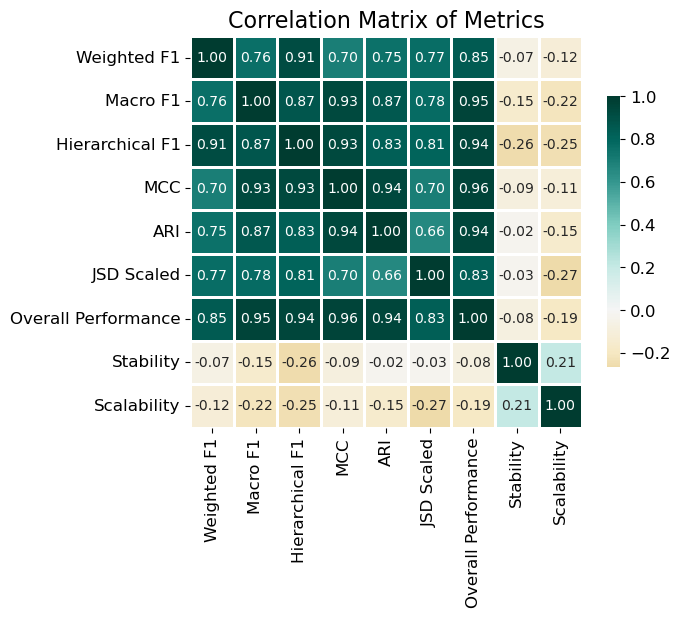

In [10]:
# pruned results to only include the relevant metrics
# get a correlation matrix of the metrics
metrics = ["f1_weighted_mean", 'macro_f1_mean', "hierarchical_f1_mean","mcc_mean","ari_mean", "jsd_scaled_mean",'weighted_score',
                                            "stability", "scalability"]
data = results[metrics].copy()
data = data.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})

correlation_matrix = data.corr()
plt.figure(figsize=(7, 7))
ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="BrBG",
    square=True,
    cbar_kws={"shrink": .5},  # removed 'center' which is not a valid argument
    annot_kws={"size": 10},
    linewidths=.75,
    center=0
)
plt.title("Correlation Matrix of Metrics", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
# Set colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "correlation_matrix_metrics.svg"), dpi=300)
plt.show()

## Heatmaps on perfromances/metrics

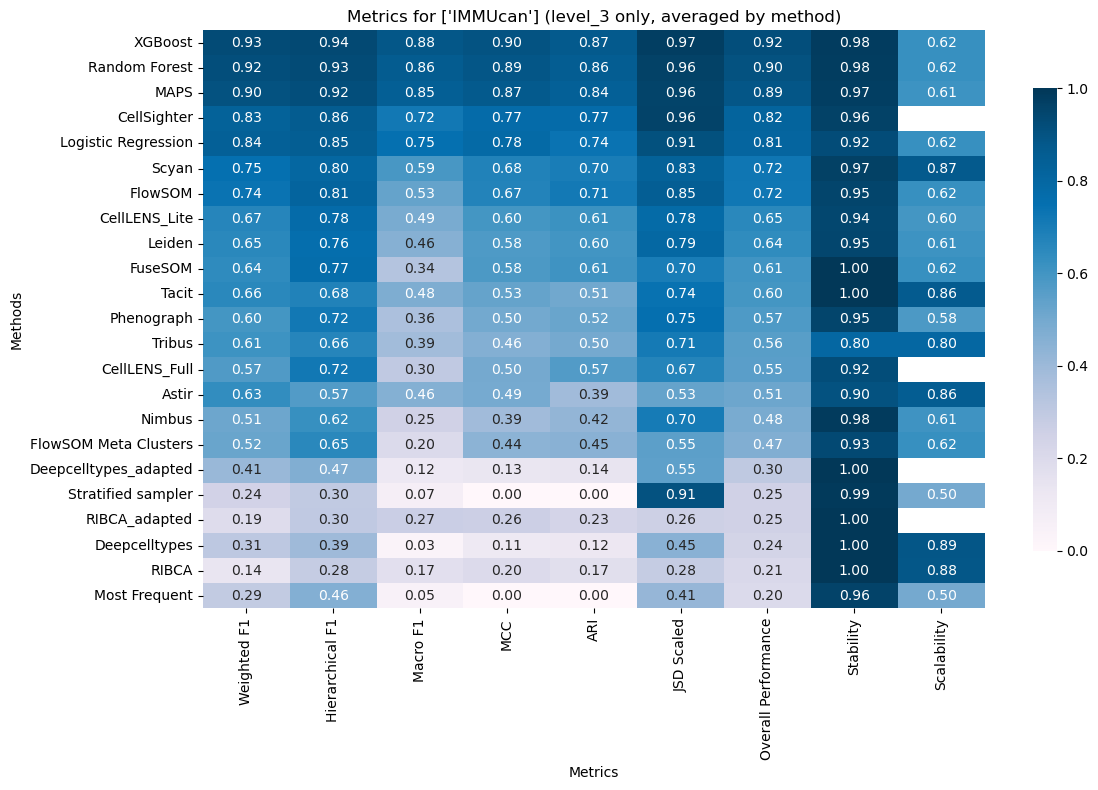

In [11]:
dataset = ["IMMUcan"] # specify the dataset to visualize
metrics = ["Weighted F1", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled",
           "Overall Performance", "Stability", "Scalability"]

# take mean of the metrics for each method for level_3 of the selected dataset
df = results2[(results2["level"] == "level_3") & (results2["dataset"].isin(dataset))]
df = df.set_index("method")[metrics]

# Sort by Overall Performance descending, then by method name to ensure consistent order even if Overall Performance is not unique
df = df.sort_values(["Overall Performance"], ascending=[False])

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
plt.title(f"Metrics for {dataset} (level_3 only, averaged by method)")
plt.xlabel("Metrics")
plt.ylabel("Methods")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

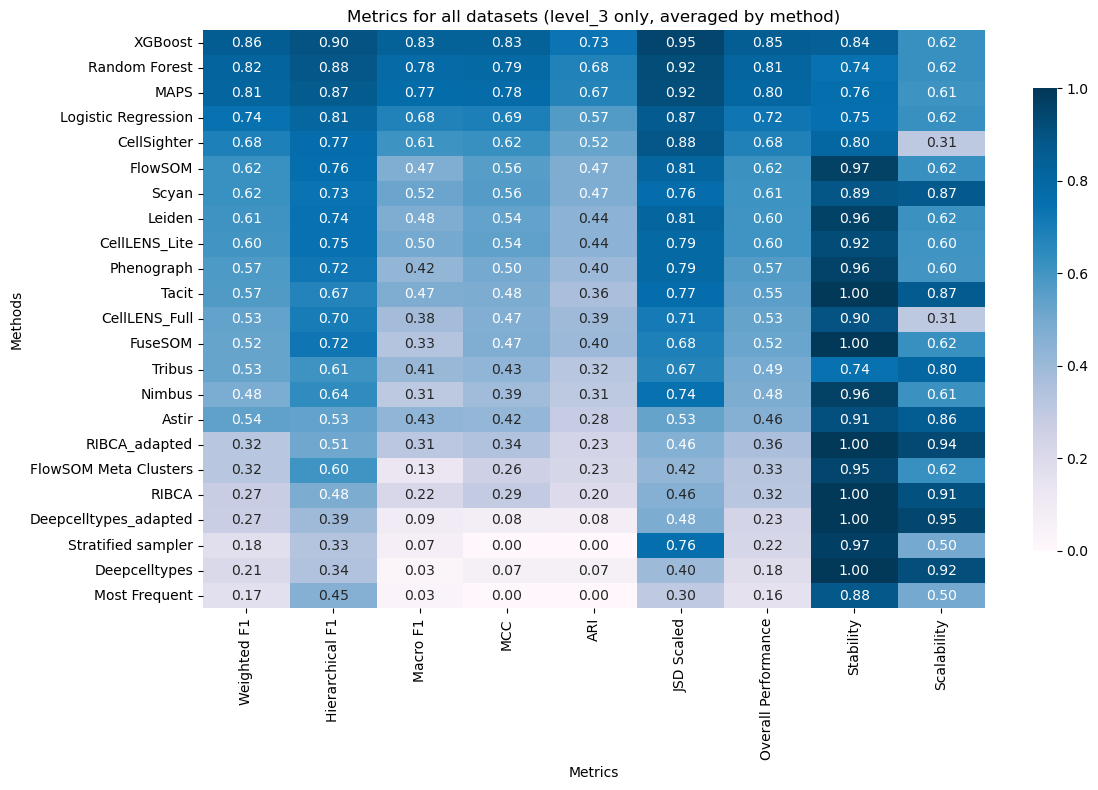

In [12]:
metrics = ["Weighted F1", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled",
           "Overall Performance", "Stability", "Scalability"]

# take mean of the metrics for each method for all datasets
df = results2[results2["level"] == "level_3"].groupby("method")[metrics].mean()

# Sort by Overall Performance descending, then by method name to ensure consistent order even if Overall Performance is not unique
df = df.sort_values(["Overall Performance"], ascending=[False])

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
plt.title("Metrics for all datasets (level_3 only, averaged by method)")
plt.xlabel("Metrics")
plt.ylabel("Methods")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# save average results for the funkyheatmap
df.to_csv("final_results_averaged.csv", sep=";")

## Minimal cell types results

In [14]:
base_path = "results"
output_path = 'figure_plots'
datasets = ["cHL_2_MIBI", "IMMUcan"]
#datasets = ["cHL_2_MIBI"]
min_results = []
for dataset in datasets:
    df = pd.read_csv(os.path.join(base_path, dataset, "minimal_results_cancer.csv"), sep=";")
    df["dataset"] = dataset
    min_results.append(df)

min_results = pd.concat(min_results, ignore_index=True)
min_results["method"] = min_results["method"].replace(method_rename)
# rename the methods to be more readable
min_results["train_time_mean"] = min_results["train_time_mean"].fillna(0)
min_results["train_time_mean"] = np.where(min_results["train_time_mean"] == min_results["inference_time_mean"], 0, min_results["train_time_mean"])
min_results["run_time"] = min_results["train_time_mean"] + min_results["inference_time_mean"]

# scale run_time to be between 0 and 1 with a threshold
runtime_thresh = 10800
min_results["runtime_scaled"] = 1 - min_results['run_time'] / runtime_thresh
min_results.loc[min_results['runtime_scaled'] < 0, 'runtime_scaled'] = 0

In [15]:
mask_l3 = min_results['level'] == 'level_3'
mask_l1_l2 = min_results['level'].isin(['level_1', 'level_2'])

min_results.loc[mask_l3, 'weighted_score'] = min_results.loc[mask_l3, metrics_for_l3].mean(axis=1)
min_results.loc[mask_l1_l2, 'weighted_score'] = min_results.loc[mask_l1_l2, metrics_for_l1_l2].mean(axis=1)

In [16]:
min_results

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,jsd_scaled_std,kl_divergence_std,kl_scaled_std,train_time_std,inference_time_std,stability,dataset,run_time,runtime_scaled,weighted_score
0,CellLENS_Lite,level_1,0.949862,NaN,0.940769,0.367414,0.721987,0.417401,0.405862,0.999811,...,0.032653,0.344436,0.162357,NaN,0.0,0.961518,cHL_2_MIBI,802.312,0.925712,0.605981
1,CellLENS_Lite,level_2,0.811318,NaN,0.807413,0.399775,0.649601,0.509029,0.506596,0.994778,...,0.035367,0.345909,0.162309,NaN,0.0,0.920185,cHL_2_MIBI,802.312,0.925712,0.606468
2,CellLENS_Lite,level_3,0.596371,0.776172,0.589104,0.374200,0.502919,0.498102,0.493658,0.868640,...,0.022808,0.754489,0.069109,NaN,0.0,0.875501,cHL_2_MIBI,802.312,0.925712,0.546673
3,FuseSOM,level_1,0.920861,NaN,0.919808,0.239907,0.958530,0.013549,0.013263,0.994979,...,0.000000,0.000000,0.000000,NaN,0.0,1.000000,cHL_2_MIBI,81.816,0.992424,0.399082
4,FuseSOM,level_2,0.735264,NaN,0.727859,0.276646,0.705496,0.357498,0.353230,0.982533,...,0.000000,0.000000,0.000000,NaN,0.0,1.000000,cHL_2_MIBI,81.816,0.992424,0.478006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Tribus,level_2,0.777107,NaN,0.737076,0.384358,0.680610,0.545127,0.525503,0.927673,...,0.053383,0.331735,0.094859,NaN,0.0,0.859221,IMMUcan,163.080,0.984900,0.588204
188,Tribus,level_3,0.708951,0.722055,0.637272,0.243481,0.419517,0.422391,0.406222,0.929485,...,0.030048,1.043575,0.017581,NaN,0.0,0.818624,IMMUcan,163.080,0.984900,0.536686
189,XGBoost,level_1,0.957275,NaN,0.947930,0.477600,0.956358,0.891494,0.888135,0.995311,...,0.011272,0.125149,0.054773,0.0,0.0,0.976849,IMMUcan,6.536,0.999395,0.810460
190,XGBoost,level_2,0.951171,NaN,0.941138,0.552103,0.940272,0.887600,0.884524,0.998564,...,0.011228,0.125201,0.054748,0.0,0.0,0.977017,IMMUcan,6.536,0.999395,0.826475


In [17]:
# apply scaling_scores to the results dataframe
min_results["scaling_score"] = min_results["method"].map(scaling_scores)
# scalability as a mean of the scaling_scores and the runtime_scaled
min_results["scalability"] = (min_results["scaling_score"] + min_results["runtime_scaled"]) / 2
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = min_results[min_results["method"].str.startswith("phenograph_")]
leiden_rows = min_results[min_results["method"].str.startswith("leiden_")]
nimbus_rows = min_results[min_results["method"].str.startswith("nimbus_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["weighted_score"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["weighted_score"].idxmax()]
nimbus_best = nimbus_rows.loc[nimbus_rows["weighted_score"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]
nimbus_best_name = nimbus_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]
nimbus_rows = nimbus_rows[nimbus_rows["method"] == nimbus_best_name]

#from results remove phenograph and leiden rows and add the best rows
min_results = min_results[~min_results["method"].str.startswith("phenograph_")]
min_results = min_results[~min_results["method"].str.startswith("leiden_")]
min_results = min_results[~min_results["method"].str.startswith("nimbus_")]
min_results = pd.concat([min_results, phenograph_rows, leiden_rows, nimbus_rows], ignore_index=True)
overall_results_min = min_results[["method", "level", "weighted_score", "dataset"]]
overall_results_min = overall_results_min[overall_results_min['level'] == 'level_3']
overall_min = overall_results_min.pivot_table(index="method", columns=["dataset", "level"], values="weighted_score")
overall_min =  overall_min.sort_values(by=list(overall_min.columns), ascending=False)
overall_min.rename(columns={"IMMUcan": "IMMUcan_min", 'cHL_2_MIBI': 'cHL_2_MIBI_min'}, inplace=True)
overall_results = results[["method", "level", "weighted_score", "dataset"]]
overall_results = overall_results[overall_results['level'] == 'level_3']
overall_pivot = overall_results.pivot_table(index="method", columns=["dataset", "level"], values="weighted_score")
overall_pivot = overall_pivot.sort_values(by=list(overall_pivot.columns), ascending=False)
merge = pd.merge(overall_pivot, overall_min, on="method", how="inner")
col_order = ['IMMUcan', 'IMMUcan_min', 'cHL_2_MIBI', 'cHL_2_MIBI_min']
merge = merge[col_order]
sorted_by_average_min = merge.loc[merge.mean(axis=1).sort_values(ascending=False).index]

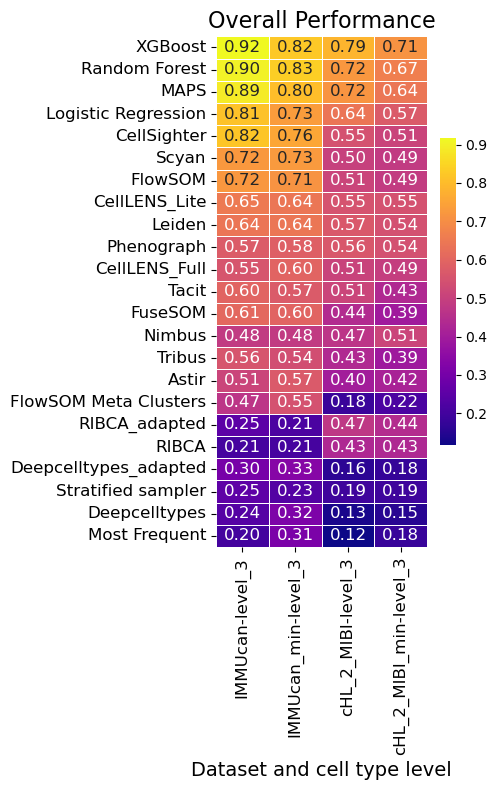

In [18]:
plt.figure(figsize=(5, 8))
sns.heatmap(sorted_by_average_min.iloc[:, :4], annot=True, fmt=".2f", cmap="plasma",
            cbar_kws={"shrink": .6}, linewidths=.6, annot_kws={"size": 12})


# Add your titles and labels
plt.title("Overall Performance", fontsize=16)
plt.xlabel("Dataset and cell type level", fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "overall_performance_minimal_cell_types.svg"), dpi=300)

In [19]:
merge['IMMUcan_diff'] = merge['IMMUcan'] - merge['IMMUcan_min']
merge['cHL_2_MIBI_diff'] = merge['cHL_2_MIBI'] - merge['cHL_2_MIBI_min']

cols = merge.columns[-2:]
sorted_by_average_min = merge.loc[merge[cols].abs().mean(axis=1).sort_values(ascending=False).index]

mask = np.zeros_like(sorted_by_average_min, dtype=bool)
mask[:, :-2] = True

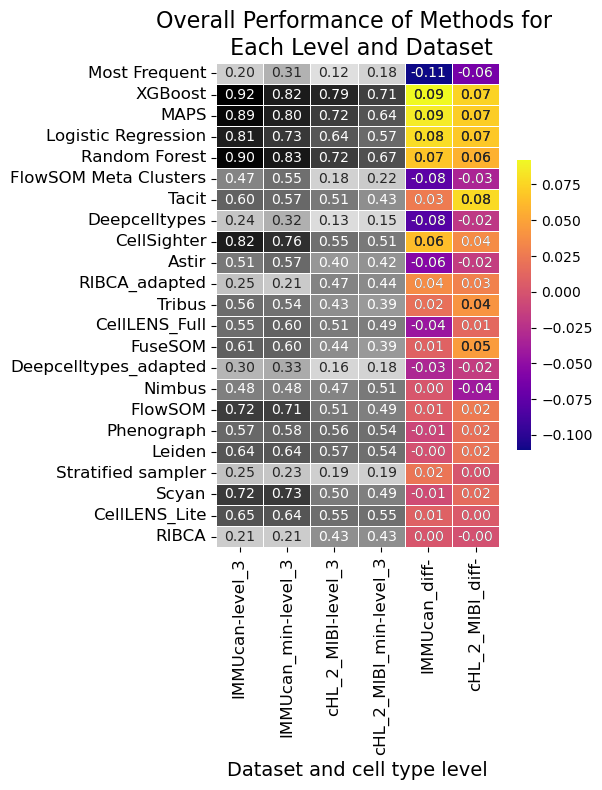

In [20]:
# plot a heatmap of the overall performance of each method for each level for each dataset sepaarated
plt.figure(figsize=(6, 8))
sns.heatmap(sorted_by_average_min, annot=True, fmt=".2f", cmap="Greys",
            cbar=False, linewidths=.6, annot_kws={"size": 10})

# Now, overlay the second heatmap for the specific columns.
# We use the mask to only draw the last two columns.
# The `plasma` colormap is applied here, and a new color bar is drawn for it.
sns.heatmap(sorted_by_average_min, annot=True, fmt=".2f", mask=mask, cmap="plasma",
            cbar_kws={"shrink": .6}, linewidths=.6, annot_kws={"size": 10})


# Add your titles and labels
plt.title("Overall Performance of Methods for \n Each Level and Dataset", fontsize=16)
plt.xlabel("Dataset and cell type level", fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("")
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure if you want
plt.savefig("partially_colored_heatmap.png", dpi=300)

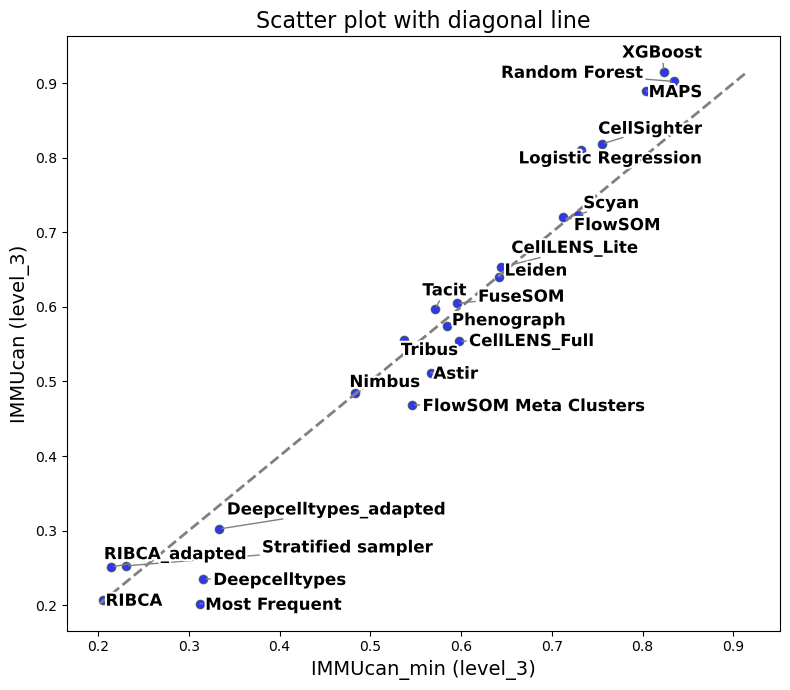

<Figure size 640x480 with 0 Axes>

In [ ]:


fig, ax = plt.subplots(figsize=(8, 7))

x = sorted_by_average_min[('IMMUcan_min', 'level_3')]
y = sorted_by_average_min[('IMMUcan', 'level_3')]

ax.scatter(x, y, color='blue', edgecolor='darkslategrey', linewidth=1, alpha=0.8)

# Annotate each point with the method name, larger and bold, with white outline
texts = []
for method in x.index:
    texts.append(
        ax.text(
            x[method], y[method], method,
            fontsize=12, fontweight='bold',
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]
        )
    )

# Adjust text to avoid overlap
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray'))

# Add diagonal line
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=2)

ax.set_xlabel('IMMUcan_min (level_3)', fontsize=14)
ax.set_ylabel('IMMUcan (level_3)', fontsize=14)
ax.set_title('Scatter plot with diagonal line', fontsize=16)
plt.tight_layout()
plt.show()

# save as svg
plt.savefig(os.path.join(output_path, "scatter_immucan_min_vs_full.svg"), dpi=300)

## Heatmap with overall over all levels

In [22]:
# get the overall performance of each method for each level
overall_results = results2[["method", "level", "Overall Performance", "dataset"]]
overall_results

,method,level,Overall Performance,dataset
0,CellLENS_Lite,level_1,0.574676,cHL_2_MIBI
1,CellLENS_Lite,level_2,0.628982,cHL_2_MIBI
2,CellLENS_Lite,level_3,0.550165,cHL_2_MIBI
3,FuseSOM,level_1,0.502937,cHL_2_MIBI
4,FuseSOM,level_2,0.583879,cHL_2_MIBI
...,...,...,...,...
133,Nimbus,level_2,0.547556,cHL_2_MIBI
134,Nimbus,level_3,0.469838,cHL_2_MIBI
135,Nimbus,level_1,0.570062,IMMUcan
136,Nimbus,level_2,0.548107,IMMUcan


In [23]:
# pivot table for overall performance of each method for each level
overall_pivot = overall_results.pivot_table(index="method", columns=["dataset", "level"], values="Overall Performance")
overall_pivot = overall_pivot.sort_values(by=list(overall_pivot.columns), ascending=False)
overall_pivot

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.921483  0.919215  0.915736   0.683151  0.825127   
Random Forest          0.912576  0.909539  0.902379   0.653775  0.784071   
MAPS                   0.898657  0.896104  0.889596   0.790284  0.770114   
CellSighter            0.842291  0.835423  0.818695   0.517807  0.601115   
Logistic Regression    0.829565  0.820559  0.810906   0.585309  0.695080   
FlowSOM                0.782344  0.772680  0.719940   0.518399  0.625621   
Scyan                  0.738822  0.734621  0.723296   0.503032  0.558051   
FuseSOM                0.711826  0.695178  0.605021   0.502937  0.583879   
CellLENS_Lite          0.700581  0.696273  0.653091   0.574676  0.628982   
Leiden                 0.687129  0.678108  0.639488   0.583416  0.668729   
Tacit                  0.667178  0.633857  0.597502   0.543753  0.598855   
FlowSOM Meta Clusters  0.659197  0.545862  0.468576   0.359252  0.269743   
CellLENS_Full          0.639322  0.619458  0.554334   0.548474  0.588992   
Phenograph             0.636606  0.630288  0.574905   0.585219  0.666453   
Tribus                 0.630094  0.606241  0.555435   0.489360  0.450971   
Nimbus                 0.570062  0.548107  0.484814   0.485591  0.547556   
Astir                  0.490683  0.495707  0.511870   0.349942  0.388486   
Deepcelltypes_adapted  0.431560  0.367429  0.302176   0.296082  0.269970   
Deepcelltypes          0.327047  0.257995  0.235304   0.253742  0.222291   
Stratified sampler     0.318470  0.291081  0.252703   0.336408  0.268107   
RIBCA_adapted          0.219233  0.246601  0.251105   0.491577  0.589447   
RIBCA                  0.202737  0.222908  0.207406   0.437761  0.520921   
Most Frequent          0.172686  0.166375  0.201980   0.359691  0.184328   

dataset                          
level                   level_3  
method                           
XGBoost                0.785118  
Random Forest          0.722392  
MAPS                   0.715369  
CellSighter            0.545613  
Logistic Regression    0.638628  
FlowSOM                0.511097  
Scyan                  0.500995  
FuseSOM                0.440563  
CellLENS_Lite          0.550165  
Leiden                 0.565085  
Tacit                  0.510696  
FlowSOM Meta Clusters  0.184086  
CellLENS_Full          0.506764  
Phenograph             0.561892  
Tribus                 0.432783  
Nimbus                 0.469838  
Astir                  0.400776  
Deepcelltypes_adapted  0.161100  
Deepcelltypes          0.132413  
Stratified sampler     0.192713  
RIBCA_adapted          0.473715  
RIBCA                  0.430376  
Most Frequent          0.117754

In [24]:
sorted_by_average = overall_pivot.loc[overall_pivot.mean(axis=1).sort_values(ascending=False).index]
sorted_by_average

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.921483  0.919215  0.915736   0.683151  0.825127   
MAPS                   0.898657  0.896104  0.889596   0.790284  0.770114   
Random Forest          0.912576  0.909539  0.902379   0.653775  0.784071   
Logistic Regression    0.829565  0.820559  0.810906   0.585309  0.695080   
CellSighter            0.842291  0.835423  0.818695   0.517807  0.601115   
FlowSOM                0.782344  0.772680  0.719940   0.518399  0.625621   
Leiden                 0.687129  0.678108  0.639488   0.583416  0.668729   
CellLENS_Lite          0.700581  0.696273  0.653091   0.574676  0.628982   
Scyan                  0.738822  0.734621  0.723296   0.503032  0.558051   
Phenograph             0.636606  0.630288  0.574905   0.585219  0.666453   
Tacit                  0.667178  0.633857  0.597502   0.543753  0.598855   
FuseSOM                0.711826  0.695178  0.605021   0.502937  0.583879   
CellLENS_Full          0.639322  0.619458  0.554334   0.548474  0.588992   
Tribus                 0.630094  0.606241  0.555435   0.489360  0.450971   
Nimbus                 0.570062  0.548107  0.484814   0.485591  0.547556   
Astir                  0.490683  0.495707  0.511870   0.349942  0.388486   
FlowSOM Meta Clusters  0.659197  0.545862  0.468576   0.359252  0.269743   
RIBCA_adapted          0.219233  0.246601  0.251105   0.491577  0.589447   
RIBCA                  0.202737  0.222908  0.207406   0.437761  0.520921   
Deepcelltypes_adapted  0.431560  0.367429  0.302176   0.296082  0.269970   
Stratified sampler     0.318470  0.291081  0.252703   0.336408  0.268107   
Deepcelltypes          0.327047  0.257995  0.235304   0.253742  0.222291   
Most Frequent          0.172686  0.166375  0.201980   0.359691  0.184328   

dataset                          
level                   level_3  
method                           
XGBoost                0.785118  
MAPS                   0.715369  
Random Forest          0.722392  
Logistic Regression    0.638628  
CellSighter            0.545613  
FlowSOM                0.511097  
Leiden                 0.565085  
CellLENS_Lite          0.550165  
Scyan                  0.500995  
Phenograph             0.561892  
Tacit                  0.510696  
FuseSOM                0.440563  
CellLENS_Full          0.506764  
Tribus                 0.432783  
Nimbus                 0.469838  
Astir                  0.400776  
FlowSOM Meta Clusters  0.184086  
RIBCA_adapted          0.473715  
RIBCA                  0.430376  
Deepcelltypes_adapted  0.161100  
Stratified sampler     0.192713  
Deepcelltypes          0.132413  
Most Frequent          0.117754

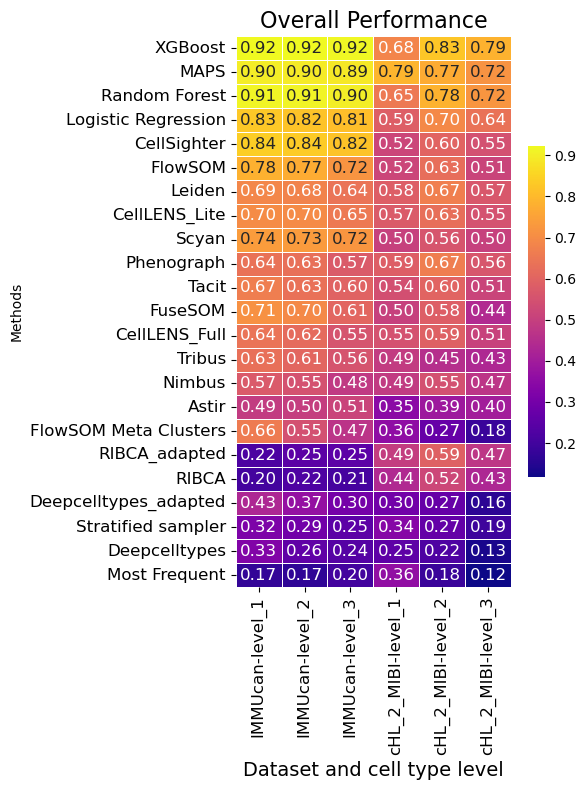

In [25]:
# plot a heatmap of the overall performance of each method for each level for each dataset sepaarated
plt.figure(figsize=(6, 8))
sns.heatmap(sorted_by_average, annot=True, fmt=".2f", cmap="plasma", cbar_kws={"shrink": .6}, annot_kws={"size": 12}, linewidths=.6)
plt.title("Overall Performance", fontsize=16)
plt.xlabel("Dataset and cell type level", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Methods")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "overall_performance_heatmap_granularities.svg"), dpi=300)
plt.show()

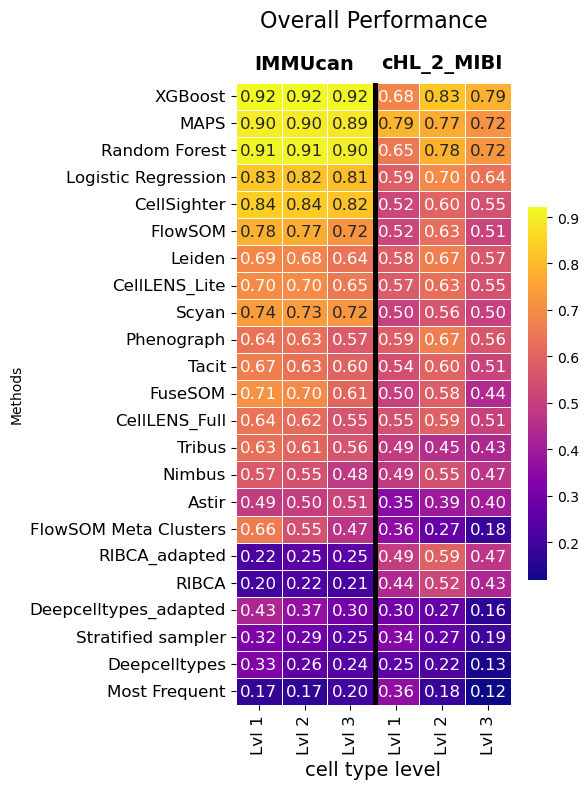

In [26]:
# Prepare custom x-tick labels
datasets = ["IMMUcan", "cHL_2_MIBI"]
levels = ["level_1", "level_2", "level_3"]
xtick_labels = [f"Lvl {lvl.split('_')[1]}" for ds in datasets for lvl in levels]

# Prepare dataset labels for the second row
dataset_labels = []
for ds in datasets:
    dataset_labels.extend([ds] * len(levels))

plt.figure(figsize=(6, 8))
ax = sns.heatmap(
    sorted_by_average,
    annot=True,
    fmt=".2f",
    cmap="plasma",
    cbar_kws={"shrink": .6},
    annot_kws={"size": 12},
    linewidths=.6
)
plt.title("Overall Performance", fontsize=16, pad=40)
plt.xlabel("cell type level", fontsize=14)
plt.ylabel("Methods")

# Set the top row (levels)
ax.set_xticks(np.arange(len(xtick_labels)) + 0.5)
ax.set_xticklabels(xtick_labels, fontsize=12, rotation=0, ha='center')

# Add the bottom row (datasets)
for i, ds in enumerate(datasets):
    xpos = i * len(levels) + 1.5
    ax.text(xpos, -0.7, ds, fontsize=14, ha='center', va='center', fontweight='bold', color='black')

plt.yticks(fontsize=12)
plt.xticks(rotation=90)

# Add white vertical gap between datasets
gap_col = len(levels)  # index after first dataset
ax.add_patch(plt.Rectangle((gap_col, 0), 0.10, sorted_by_average.shape[0], color='black', zorder=10, linewidth=0))

plt.tight_layout()
plt.savefig(os.path.join(output_path, "overall_performance_heatmap_granularities.svg"), dpi=300)
plt.show()

## Overall bar-plot performances over all methods and datasets

In [27]:
overall_performance = results.groupby("method")["weighted_score"].mean().sort_values(ascending=False).reset_index()
overall_performance

,method,weighted_score
0,XGBoost,0.841638
1,MAPS,0.826687
2,Random Forest,0.814122
3,Logistic Regression,0.730008
4,CellSighter,0.693491
5,FlowSOM,0.655014
6,Leiden,0.636992
7,CellLENS_Lite,0.633961
8,Scyan,0.626469
9,Phenograph,0.609227


In [28]:
# Prepare method group mapping for each method
method_to_group = {}
for group, methods in method_groups.items():
    for m in methods:
        method_to_group[m] = group

# Use readable names from method_rename
method_to_group.update({method_rename.get(k, k): v for k, v in method_to_group.items()})

# Create a DataFrame for plotting
plot_df = overall_performance.reset_index()
plot_df["group"] = plot_df["method"].map(method_to_group).fillna("Other")

# Sort by group, then by score
plot_df = plot_df.sort_values(["group", "weighted_score"], ascending=[True, False])

# # Add horizontal dotted lines for baselines
# baseline_scores = plot_df[plot_df["group"] == "baselines"]["overall_score"]
# for score in baseline_scores:
#     plt.axhline(y=score, color='gray', linestyle='--', linewidth=0.8)
    
# plt.figure(figsize=(14, 7))
# sns.barplot(x="method", y="overall_score", hue="group", data=plot_df, dodge=False, palette="gist_earth")
# plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
# plt.xlabel("Method")
# plt.ylabel("Overall Score")
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

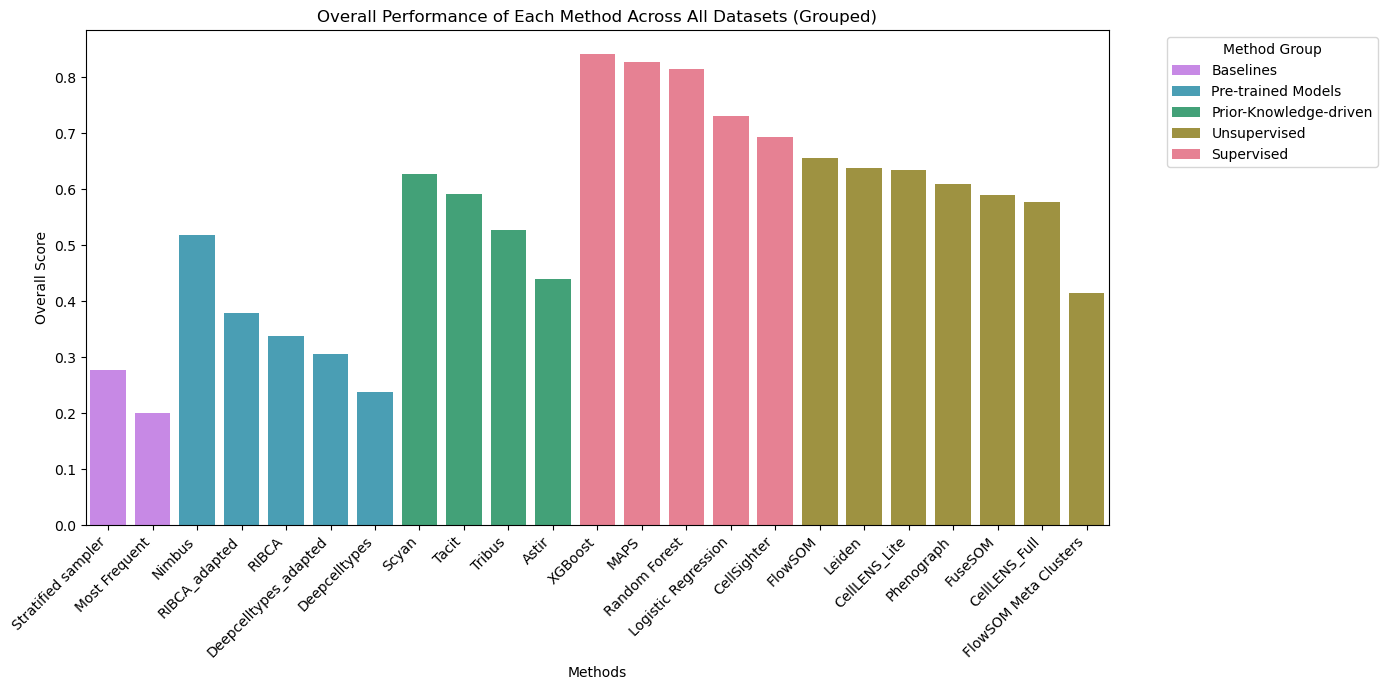

In [29]:
# Compute mean overall_score per group
group_order = plot_df.groupby("group")["weighted_score"].mean().sort_values(ascending=True).index.tolist()

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x="method",
    y="weighted_score",
    hue="group",
    data=plot_df,
    dodge=False,
    palette=method_cmap,
    hue_order=group_order
)

# Add horizontal dotted lines for baselines
baseline_scores = plot_df[plot_df["group"] == "baselines"]["weighted_score"]
for score in baseline_scores:
    plt.axhline(score, color="gray", linestyle=":", linewidth=2, alpha=0.7)

plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
plt.xlabel("Methods")
plt.ylabel("Overall Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Overall Rank Chart

In [30]:
results2

,method,dataset,level,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability
0,CellLENS_Lite,cHL_2_MIBI,level_1,0.856754,NaN,0.444080,0.387539,0.410074,0.774934,0.574676,0.965411,0.611071
1,CellLENS_Lite,cHL_2_MIBI,level_2,0.729420,NaN,0.612457,0.523316,0.386250,0.893468,0.628982,0.944437,0.611071
2,CellLENS_Lite,cHL_2_MIBI,level_3,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.611071
3,FuseSOM,cHL_2_MIBI,level_1,0.837625,NaN,0.304318,0.271765,0.404176,0.696802,0.502937,1.000000,0.623580
4,FuseSOM,cHL_2_MIBI,level_2,0.712334,NaN,0.510239,0.501264,0.332743,0.862814,0.583879,1.000000,0.623580
...,...,...,...,...,...,...,...,...,...,...,...,...
133,Nimbus,cHL_2_MIBI,level_2,0.675119,NaN,0.469802,0.423068,0.292847,0.876944,0.547556,0.944500,0.619168
134,Nimbus,cHL_2_MIBI,level_3,0.454613,0.654543,0.361780,0.386926,0.186675,0.774488,0.469838,0.945550,0.619168
135,Nimbus,IMMUcan,level_1,0.682415,NaN,0.475787,0.508202,0.347343,0.836564,0.570062,0.960926,0.607995
136,Nimbus,IMMUcan,level_2,0.623969,NaN,0.442786,0.468425,0.373332,0.832024,0.548107,0.981908,0.607995


In [31]:
#take rows where level is level_3
results_lvl3 = results2[results2["level"] == "level_3"]
# pivot dataset and overall score
rank_results = results_lvl3.pivot(index=["method"], columns="dataset", values=["Overall Performance"])
# keep only the dataset name as the column name
rank_results.columns = rank_results.columns.droplevel(0)

rank_results['avg_score'] = rank_results.mean(axis=1)
#rank_results['rank'] = rank_results['avg_score'].rank(ascending=False, method='min')
rank_results

dataset,IMMUcan,cHL_2_MIBI,avg_score
method,,,
Astir,0.511870,0.400776,0.456323
CellLENS_Full,0.554334,0.506764,0.530549
CellLENS_Lite,0.653091,0.550165,0.601628
CellSighter,0.818695,0.545613,0.682154
Deepcelltypes,0.235304,0.132413,0.183858
Deepcelltypes_adapted,0.302176,0.161100,0.231638
FlowSOM,0.719940,0.511097,0.615519
FlowSOM Meta Clusters,0.468576,0.184086,0.326331
FuseSOM,0.605021,0.440563,0.522792


In [32]:
# Step 1: Compute ranks (lower rank = better performance)
rank_df = rank_results.rank(ascending=False, axis=0)
# order by the avg_score   
rank_df = rank_df.sort_values(by='avg_score', ascending=True)
rank_df = rank_df[['cHL_2_MIBI', 'IMMUcan', 'avg_score']]
rank_df = rank_results.rank(ascending=True, axis=0)
datasets = rank_df.columns
methods = rank_df.index

# Sort methods by mean rank
rank_df = rank_df.loc[rank_df.mean(axis=1).sort_values().index]

In [33]:
rank_df

dataset,IMMUcan,cHL_2_MIBI,avg_score
method,,,
Most Frequent,1.0,1.0,1.0
Deepcelltypes,3.0,2.0,2.0
Stratified sampler,5.0,5.0,3.0
Deepcelltypes_adapted,6.0,3.0,4.0
RIBCA,2.0,7.0,5.0
FlowSOM Meta Clusters,7.0,4.0,6.0
RIBCA_adapted,4.0,11.0,7.0
Astir,9.0,6.0,8.0
Nimbus,8.0,10.0,9.0


In [34]:
def draw_curve(ax, x1, y1, x2, y2, color, linewidth=12, alpha=1):
    verts = [
        (x1, y1),                # Start point
        ((x1 + x2) / 2, y1),     # Control point 1
        ((x1 + x2) / 2, y2),     # Control point 2
        (x2, y2)                 # End point
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    path = Path(verts, codes)
    patch = PathPatch(path, facecolor='none', edgecolor=color, lw=linewidth, alpha=alpha)
    ax.add_patch(patch)

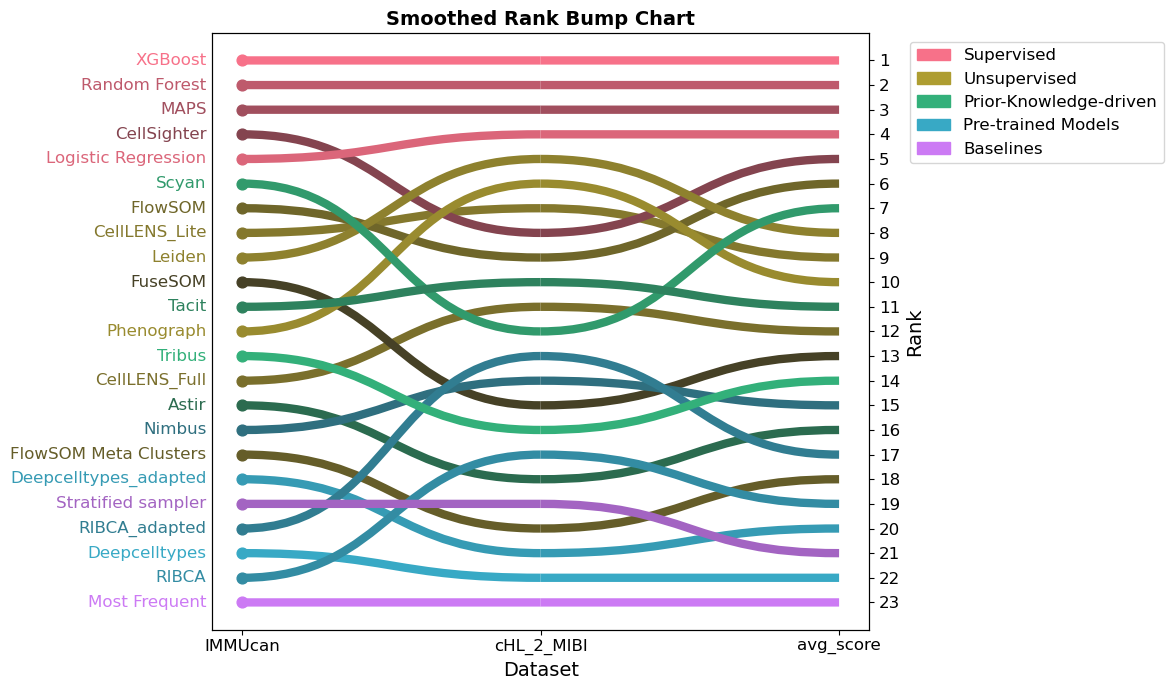

In [35]:
method_colors = {}
for group, methods_in_group in method_groups.items():
    base_color = method_cmap[group]
    
    # Create a palette starting with the base color and getting darker
    # input="rgb" ensures seaborn interprets your tuple correctly
    num_methods = len(methods_in_group)
    
    palette = sns.dark_palette(base_color, n_colors=num_methods + 3, reverse=True, input="rgb")

    for i, method in enumerate(methods_in_group):
        # Assign colors sequentially from the generated palette
        color = palette[i]
        method_colors[method] = mcolors.to_hex(color)
fig, ax = plt.subplots(figsize=(12, 7))

x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    color = method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=6)

    # Start and end dots
    ax.scatter(x_vals[0], y[0], color=color, s=60, zorder=2)
    ax.text(x_vals[0] - 0.12, y[0], method, ha='right', va='center', color=color, fontsize=12)

# Right y-axis: rank labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(1, len(rank_df) + 1))
ax2.set_yticklabels(range(1, len(rank_df) + 1), fontsize=12)
ax2.set_ylabel("Rank", fontsize=14)
ax2.invert_yaxis()

# Style
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(axis='y', left=False)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_title("Smoothed Rank Bump Chart", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend for method groups
legend_handles = []
for group, color in method_cmap.items():
    legend_handles.append(mpatches.Patch(color=to_hex(color), label=group))
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join(output_path, "smoothed_rank_bump_chart.svg"), format='svg', bbox_inches='tight')
plt.show()


## Hierarcheal F1 score

In [36]:
#read the hierarchy mappings from the file
with open('hierarchy_mappings.pkl', 'rb') as f:
    import pickle
    hierarchy_mappings = pickle.load(f)

In [37]:
def build_tree(mapping: Dict[str, Dict[str, str]]) -> Dict:
    tree = defaultdict(lambda: defaultdict(list))
    for leaf, levels in mapping.items():
        level1 = levels['level_1_cell_type']
        level2 = levels['level_2_cell_type']
        tree[level1][level2].append(leaf)
    return tree

# Convert tree to indented text view
def tree_to_text(tree: Dict, indent: int = 0) -> str:
    lines = []
    for level1, sublevels in tree.items():
        lines.append('  ' * indent + level1)
        for level2, leaves in sublevels.items():
            lines.append('  ' * (indent + 1) + level2)
            for leaf in leaves:
                lines.append('  ' * (indent + 2) + leaf)
    return '\n'.join(lines)

# Create the tree and save it to a txt file
tree = build_tree(hierarchy_mappings)
tree_text = tree_to_text(tree)

# Save to a text file
file_path = "cell_type_hierarchy.txt"
with open(file_path, "w") as f:
    f.write(tree_text)

In [38]:
def parse_tree_file(file_path: str) -> dict:
    """Parses a 2-space-indented tree file and returns label -> ancestor path mapping."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    label_to_ancestors = {}
    path_stack = []

    for line in lines:
        stripped = line.lstrip()
        indent = len(line) - len(stripped)
        level = indent // 2  # Assumes 2 spaces per indent

        path_stack = path_stack[:level]
        path_stack.append(stripped.strip())

        if level >= 2:
            label = path_stack[-1]
            label_to_ancestors[label] = path_stack[:-1]  # from root to parent

    return label_to_ancestors

In [39]:
file_path = "cell_type_hierarchy.txt"
ancestor_map = parse_tree_file(file_path)


## Dataset distributions

In [40]:
# import plotly.graph_objects as go

# def parse_tree_levels(file_path):
#     # Parse the indented tree file and return a list of (parent, child) pairs for all levels
#     with open(file_path, 'r') as f:
#         lines = f.readlines()

#     pairs = []
#     stack = []
#     for line in lines:
#         stripped = line.lstrip()
#         indent = len(line) - len(stripped)
#         level = indent // 2
#         stack = stack[:level]
#         stack.append(stripped.strip())
#         if level > 0:
#             pairs.append((stack[-2], stack[-1]))
#     return pairs

# def generate_sankey_from_tree(file_path):
#     pairs = parse_tree_levels(file_path)
#     labels = sorted(set([p for pair in pairs for p in pair]))
#     label_to_idx = {label: i for i, label in enumerate(labels)}
#     source = [label_to_idx[parent] for parent, child in pairs]
#     target = [label_to_idx[child] for parent, child in pairs]
#     value = [1] * len(pairs)

#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=15,
#             thickness=20,
#             line=dict(color="black", width=0.5),
#             label=labels,
#         ),
#         link=dict(
#             source=source,
#             target=target,
#             value=value,
#         )
#     )])
#     fig.update_layout(title_text="Cell Type Hierarchy Sankey Diagram (All Levels)", font_size=10)
#     fig.update_layout(width=1200, height=1000)
#     fig.show()

# generate_sankey_from_tree(file_path)


In [41]:
def parse_tree_for_sunburst(file_path):
    # Parse the indented tree file and return names and parents for sunburst
    names = []
    parents = []
    stack = []
    with open(file_path, 'r') as f:
        for line in f:
            stripped = line.lstrip()
            indent = len(line) - len(stripped)
            level = indent // 2
            name = stripped.strip()
            if not name:
                continue
            if level == 0:
                parent = ""
            else:
                parent = stack[level - 1]
            if name not in names:  # avoid duplicates
                names.append(name)
                parents.append(parent)
            if len(stack) <= level:
                stack.append(name)
            else:
                stack[level] = name

    return names, parents

def generate_radial_tree(file_path):
    names, parents = parse_tree_for_sunburst(file_path)
    fig = px.sunburst(
        names=names,
        parents=parents,
        width=1000,
        height=800,
        maxdepth=3,
        color_discrete_sequence=px.colors.qualitative.T10
    )

    fig.update_layout(
                        margin=dict(t=10, l=10, r=10, b=10)
                     )

    fig.show()

    fig.write_html(os.path.join(output_path, "sunburst_distribution.html"))
    fig.write_image(os.path.join(output_path, "sunburst_distribution.svg"))

generate_radial_tree(file_path)

## Metric accumulation

In [42]:
#rename id col to method
results_lvl3 = results_lvl3.rename(columns={"id": "method"})

In [43]:
# get methods and results[metrics] in a dataframe
results_cat = results_lvl3.set_index('method')
results_cat = results_cat[metrics]
# take mean of each metric by method
results_cat = results_cat.groupby(results_cat.index).mean()
results_cat

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability
method,,,,,,,,,
Astir,0.540685,0.534367,0.429633,0.420975,0.282387,0.529890,0.456323,0.913475,0.856551
CellLENS_Full,0.531686,0.702885,0.380603,0.467774,0.391183,0.709164,0.530549,0.900091,0.308358
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.601628,0.924021,0.603295
CellSighter,0.684711,0.767612,0.609490,0.622571,0.524018,0.884523,0.682154,0.799952,0.308358
Deepcelltypes,0.205550,0.342222,0.025556,0.066237,0.066188,0.397397,0.183858,1.000000,0.917879
Deepcelltypes_adapted,0.268449,0.393089,0.091715,0.079898,0.076427,0.480251,0.231638,1.000000,0.947198
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.615519,0.966357,0.624606
FlowSOM Meta Clusters,0.321253,0.604064,0.129491,0.255818,0.225048,0.422314,0.326331,0.949259,0.624606
FuseSOM,0.523746,0.723114,0.334678,0.472243,0.398663,0.684309,0.522792,1.000000,0.623331


/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_15523/1315850975.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



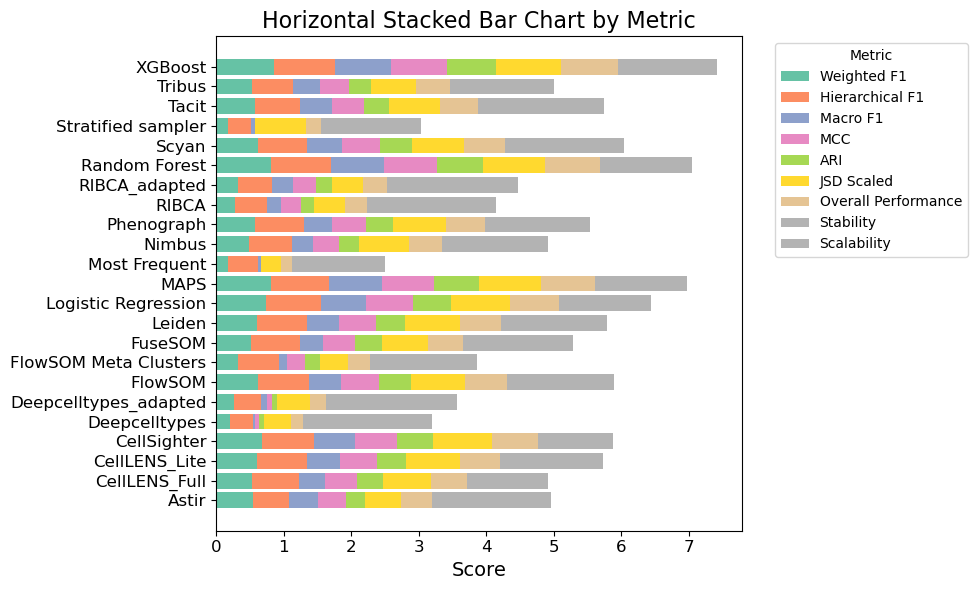

In [44]:
df = results_cat

# Check column count
n_metrics = len(df.columns)

# Choose a colormap with enough colors
from matplotlib.cm import get_cmap
cmap = get_cmap("Set2", n_metrics)  # will generate n_metrics colors
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df)

# Plot each metric as a segment
for i, col in enumerate(df.columns):
    ax.barh(df.index, df[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df[col])]

# Aesthetics
ax.set_xlabel("Score", fontsize=14)
ax.set_title("Horizontal Stacked Bar Chart by Metric", fontsize=16)
ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_15523/3399861881.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



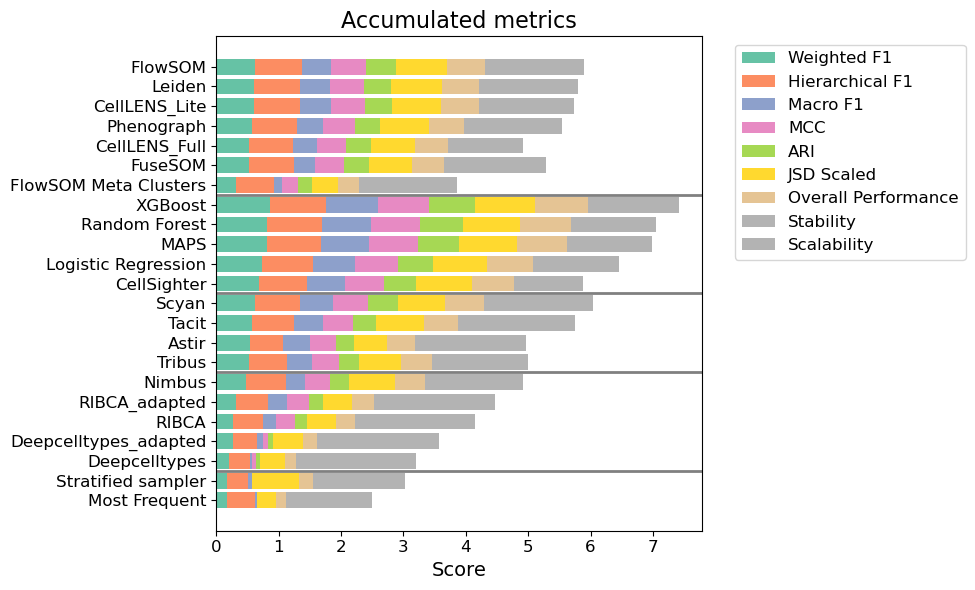

In [45]:
# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

# Step 3: Add group to your DataFrame
df['group'] = df.index.map(method_to_group)

# Step 4: Sort by group (and optionally by method name within group)
df_sorted = df.sort_values(by=['group', df.columns[0]])  # replace columns[0] with a metric name if needed

# Step 5: Plot horizontal stacked bar
metrics = [col for col in df_sorted.columns if col != 'group']
n_metrics = len(metrics)

# Generate distinct colors per metric
cmap = get_cmap("Set2", n_metrics)
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df_sorted)

for i, col in enumerate(metrics):
    ax.barh(df_sorted.index, df_sorted[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df_sorted[col])]

# Get the numeric y positions of each method
y_positions = range(len(df_sorted))

# Track the last seen group
last_group = None
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    current_group = row['group']
    if last_group is not None and current_group != last_group:
        # Draw a dotted line between groups
        ax.axhline(i - 0.5, color='gray', linestyle='-', linewidth=2)
    last_group = current_group

# Aesthetics
ax.set_xlabel("Score", fontsize=14)
ax.set_title("Accumulated metrics", fontsize=16)
ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "accumulated_metrics.svg"), dpi=300)
plt.show()

## Performance vs scalability/stability

In [46]:
df = pd.read_csv('final_results_averaged.csv', sep=';').set_index('method')
df['Method_group'] = df.index.map(method_to_group)

In [47]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
XGBoost,0.856627,0.902017,0.830166,0.830505,0.732611,0.950638,0.850427,0.841642,0.624891,Supervised
Random Forest,0.818997,0.884047,0.781759,0.789616,0.678290,0.921603,0.812385,0.741491,0.624528,Supervised
MAPS,0.810434,0.869093,0.771846,0.777161,0.668638,0.917723,0.802482,0.755027,0.610894,Supervised
Logistic Regression,0.740831,0.805969,0.676752,0.691181,0.568661,0.865211,0.724767,0.751804,0.624911,Supervised
CellSighter,0.684711,0.767612,0.609490,0.622571,0.524018,0.884523,0.682154,0.799952,0.308358,Supervised
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.615519,0.966357,0.624606,Unsupervised
Scyan,0.617996,0.734390,0.518945,0.562744,0.474503,0.764295,0.612146,0.888289,0.872273,Prior-Knowledge-driven
Leiden,0.606361,0.742242,0.475343,0.538165,0.440368,0.811239,0.602286,0.963828,0.615077,Unsupervised
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.601628,0.924021,0.603295,Unsupervised


In [48]:
df["Scalability/Stability"] = (df["Scalability"] + df["Stability"]) / 2
fig = px.scatter(df, x="Scalability/Stability", y="Overall Performance", color="Method_group",
                 size='Macro F1', hover_data=[df.index,'Overall Performance', 'Scalability/Stability', 'Macro F1'],)

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(width=800, height=600)

fig.update_layout(
    template='simple_white',
    title="Performance vs Scalability/Stability",
    xaxis=dict(title="Scalability/Stability", range=[0.45, 1]),
    #xaxis=dict(title="Scalability/Stability"),
    yaxis=dict(title="Performance Overall")
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))


fig.show()

fig.write_html(os.path.join(output_path, "scatter_plot_grouped.html"))

# save as svg
fig.write_image(os.path.join(output_path, "scatter_plot_grouped.svg"), width=800, height=600, scale=2)

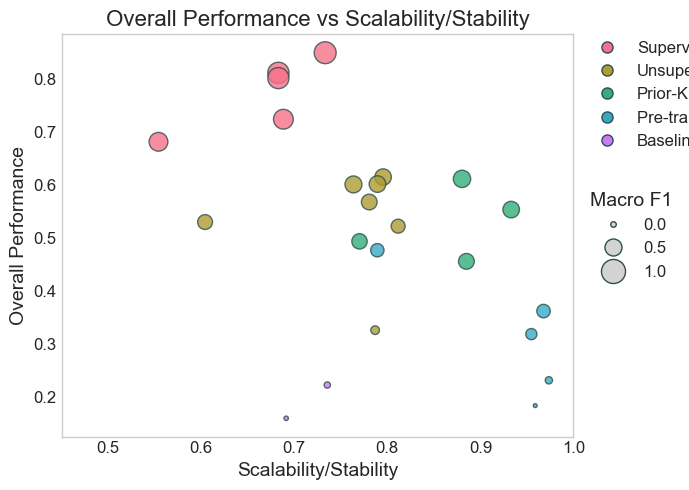

In [49]:

# Use the correct seaborn style depending on matplotlib version
methodologies = df["Method_group"].unique()
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn-v0_8-whitegrid' in available_styles:
    plt.style.use('seaborn-v0_8-whitegrid')
else:
    plt.style.use('default')

fig, ax = plt.subplots(figsize=(7, 5))

# Scatter plot points
for method in methodologies:
    subset = df[df["Method_group"] == method]
    ax.scatter(
        subset["Scalability/Stability"],
        subset["Overall Performance"],
        s=subset["Macro F1"] * 300,  # scaled size
        color=method_cmap[method],
        edgecolor='darkslategrey',
        linewidth=1,
        alpha=0.8
    )

# ---------- Legend 1: Methodology colors ----------
color_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=method,
        markerfacecolor=method_cmap[method],
        markeredgecolor='darkslategrey',
        markersize=8
    )
    for method in methodologies
]
legend1 = ax.legend(
    handles=color_handles,
    title="",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.85),
    borderaxespad=0
)
legend1._legend_title_box._text.set_ha("left")  # align left
ax.add_artist(legend1)

# ---------- Legend 2: Dot size for Macro F1 ----------
# Example size values
size_values = [0, 0.5, 1]
size_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"{v:.1f}",
        markerfacecolor='lightgray',
        markeredgecolor='darkslategrey',
        markersize=np.sqrt(v * 300) if v > 0 else 4  # match scatter scaling
    )
    for v in size_values
]

legend2 = ax.legend(
    handles=size_handles,
    title="Macro F1",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
legend2._legend_title_box._text.set_ha("left")  # align left

# Titles & labels
ax.set_title("Overall Performance vs Scalability/Stability", fontsize=16)
ax.set_xlabel("Scalability/Stability", fontsize=14)
ax.set_ylabel("Overall Performance", fontsize=14)
ax.set_xlim(0.45, 1)
ax.tick_params(axis='both', labelsize=12)

ax.grid(False)

plt.tight_layout()
plt.show()

# save as svg
fig.savefig(os.path.join(output_path, "performance_vs_scalability.svg"), format="svg", bbox_inches="tight")

## barplot

In [50]:
# take mean of the metrics for each method for all datasets
df = results[results["level"] == "level_3"]
#set methods to index
df = df.set_index("method")

# rename the columns to be more readable
df = df.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})


# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

df['Method_group'] = df.index.map(method_to_group)

# move the "Overall Performance" to before "Stability" and "Scalability"
df = df[["Weighted F1", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled", 
         "Overall Performance",
         "Stability", "Scalability",
         "Method_group"]]

df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
CellLENS_Lite,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.611071,Unsupervised
FuseSOM,0.406693,0.678629,0.334189,0.363712,0.189817,0.670341,0.440563,1.000000,0.623580,Unsupervised
Astir,0.446390,0.502145,0.401245,0.347341,0.176701,0.530833,0.400776,0.922862,0.857259,Prior-Knowledge-driven
CellLENS_Full,0.490461,0.687217,0.461476,0.437024,0.215611,0.748798,0.506764,0.879579,0.308358,Unsupervised
CellSighter,0.540896,0.674215,0.503694,0.471019,0.273499,0.810358,0.545613,0.636101,0.308358,Supervised
Deepcelltypes,0.105539,0.293347,0.018142,0.022256,0.009187,0.346006,0.132413,1.000000,0.947198,Pre-trained Models
Deepcelltypes_adapted,0.127358,0.320875,0.065562,0.026625,0.010777,0.415401,0.161100,1.000000,0.947198,Pre-trained Models
FlowSOM,0.504021,0.699099,0.409361,0.446718,0.233960,0.773426,0.511097,0.981606,0.624712,Unsupervised
FlowSOM Meta Clusters,0.121728,0.555337,0.056644,0.074018,0.002628,0.294160,0.184086,0.964428,0.624712,Unsupervised


In [51]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

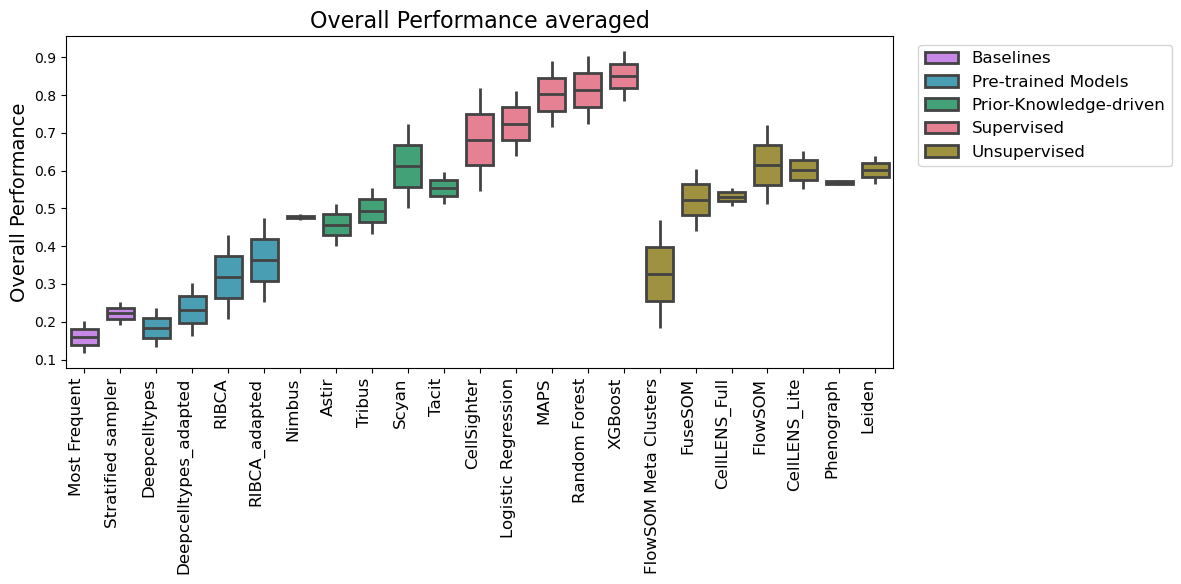

In [52]:
# Sort the dataframe by group and method
df_sorted = df.sort_values(by=["Method_group", "method"])
df_sorted = df_sorted.sort_values(by=['Method_group', 'Overall Performance'], ascending=[True, True])

# Get the order of methods after sorting (includes duplicates)
method_order = df_sorted.index.tolist()

# Use the correct seaborn style depending on matplotlib version
plt.style.use('default')

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_sorted,
    x="method",
    y="Overall Performance",
    hue="Method_group",
    palette=method_cmap,
    dodge=False,
    order=method_order,
    showcaps=False,
    linewidth=2,
    width=0.75
)

# Set font sizes
plt.rcParams.update({'font.size': 12})  # Default font size
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.xlabel('', fontsize=14)
plt.ylabel('Overall Performance', fontsize=14)
plt.title('Overall Performance averaged', fontsize=16)

# Move legend outside the plot with custom font sizes
legend = plt.legend(title="", bbox_to_anchor=(1.02, 1), loc='upper left')
legend.get_title().set_fontsize(14)
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()

# save as svg
plt.savefig(os.path.join(output_path, "boxplot_performance_overall.svg"), format='svg', bbox_inches='tight', dpi=300)

plt.show()

## Pareto 

In [53]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
CellLENS_Lite,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.611071,Unsupervised
FuseSOM,0.406693,0.678629,0.334189,0.363712,0.189817,0.670341,0.440563,1.000000,0.623580,Unsupervised
Astir,0.446390,0.502145,0.401245,0.347341,0.176701,0.530833,0.400776,0.922862,0.857259,Prior-Knowledge-driven
CellLENS_Full,0.490461,0.687217,0.461476,0.437024,0.215611,0.748798,0.506764,0.879579,0.308358,Unsupervised
CellSighter,0.540896,0.674215,0.503694,0.471019,0.273499,0.810358,0.545613,0.636101,0.308358,Supervised
Deepcelltypes,0.105539,0.293347,0.018142,0.022256,0.009187,0.346006,0.132413,1.000000,0.947198,Pre-trained Models
Deepcelltypes_adapted,0.127358,0.320875,0.065562,0.026625,0.010777,0.415401,0.161100,1.000000,0.947198,Pre-trained Models
FlowSOM,0.504021,0.699099,0.409361,0.446718,0.233960,0.773426,0.511097,0.981606,0.624712,Unsupervised
FlowSOM Meta Clusters,0.121728,0.555337,0.056644,0.074018,0.002628,0.294160,0.184086,0.964428,0.624712,Unsupervised


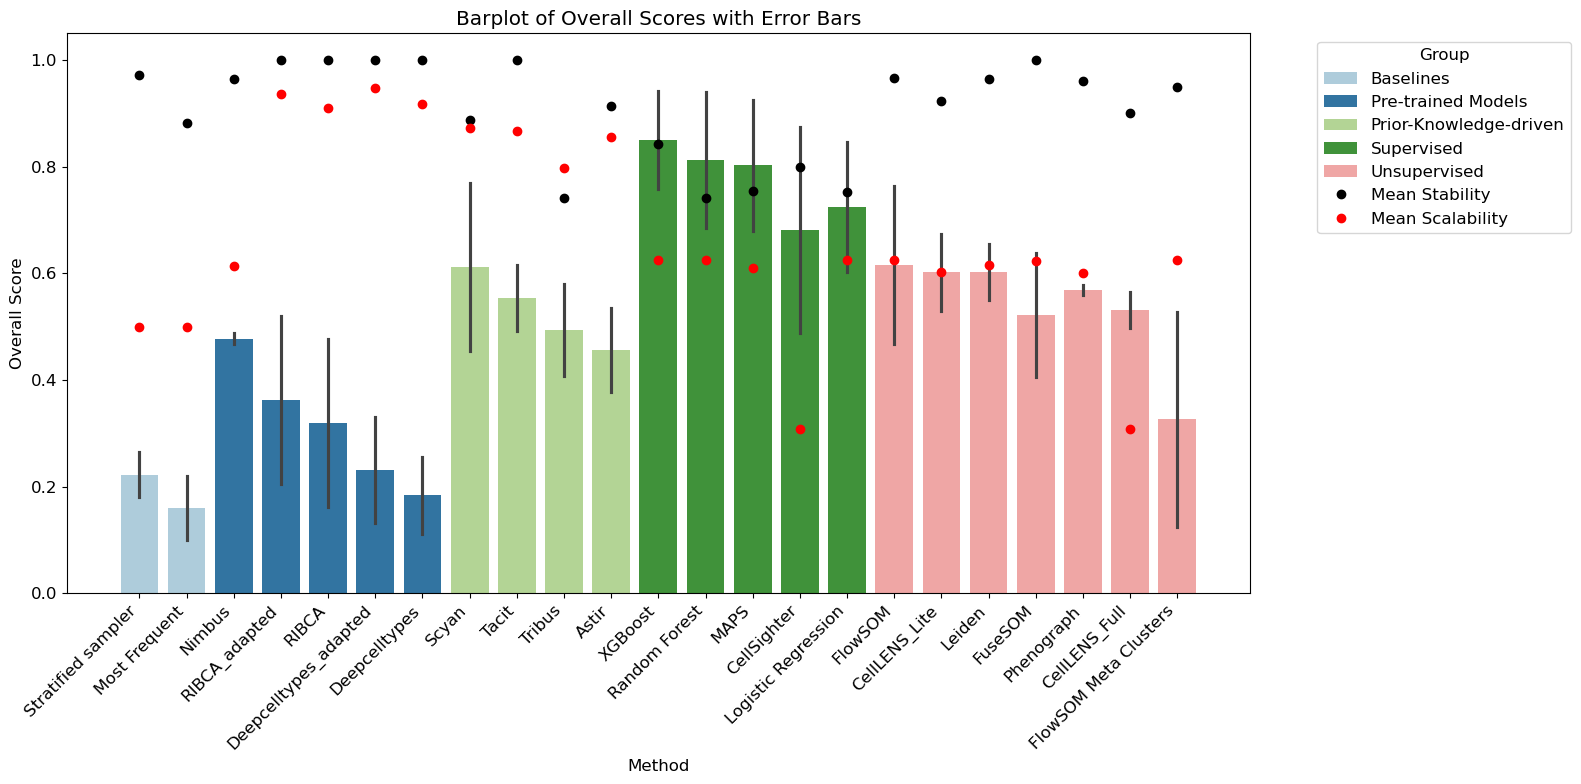

In [54]:
# Sort by scalability (descending)
#df_sorted = df_sorted.sort_values(by="Methodology", ascending=False)

df_sorted = df_sorted.sort_values(by=['Method_group', 'Overall Performance'], ascending=[True, False])  

plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_sorted,
    x="method",
    y="Overall Performance",
    hue="Method_group",
    palette="Paired",
    errorbar="sd",
    order=df_sorted.index.tolist()
)

# calculate mean scalabilty for each method
mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()


# Add mean stability of each method as dots that are connected by a single line
# Plot mean stability as dots
# Plot mean stability as dots
plt.errorbar(
    x=mean_stability["method"],
    y=mean_stability["Stability"],
    fmt='o',
    color='black',
    label='Mean Stability',
    capsize=5,
)

# Add mean stability of each method as dots that are connected by a single line
plt.errorbar(
    x=mean_stability["method"],
    y=mean_scalability["Scalability"],
    fmt='o',
    color='red',
    label='Mean Scalability',
    capsize=5,
)


# # calculate mean scalabilty for each method
# mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
# mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()

# # get the unique methods only
# unique_methods = df_sorted.index.unique().tolist()

# #order the mean_scalability and mean_stability by the unique methods
# mean_scalability = mean_scalability[mean_scalability["method"].isin(unique_methods)]
# mean_stability = mean_stability[mean_stability["method"].isin(unique_methods)]  
# # Plot mean scalability as dots and connect them with a line
# plt.plot(mean_scalability.index, mean_scalability["Scalability"], color='red', marker='o', label='Mean Scalability', linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Method')
plt.ylabel('Overall Score')
plt.title('Barplot of Overall Scores with Error Bars')
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## scalability plot

In [55]:
scalability_plot_lvl3 = results[results["level"] == "level_3"]
scalability_plot_lvl3 = scalability_plot_lvl3[["method", "train_time_mean", "inference_time_mean", "runtime_scaled", "scaling_score", "scalability"]]
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability
2,CellLENS_Lite,0.000,802.312000,0.972142,0.25,0.611071
5,FuseSOM,0.000,81.816000,0.997159,0.25,0.623580
8,Astir,0.000,1021.892000,0.964518,0.75,0.857259
11,CellLENS_Full,12114.000,6124.600000,0.366715,0.25,0.308358
14,CellSighter,12114.000,6124.600000,0.366715,0.25,0.308358
17,Deepcelltypes,0.000,3041.386000,0.894396,1.00,0.947198
20,Deepcelltypes_adapted,0.000,3041.386000,0.894396,1.00,0.947198
23,FlowSOM,0.000,16.612000,0.999423,0.25,0.624712
26,FlowSOM Meta Clusters,0.000,16.612000,0.999423,0.25,0.624712
29,Logistic Regression,2.040,1.036000,0.999893,0.25,0.624947


In [56]:
# get the mean by method
scalability_plot_lvl3 = scalability_plot_lvl3.groupby("method").mean().reset_index()
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability
0,Astir,0.000,1062.672000,0.963102,0.75,0.856551
1,CellLENS_Full,6057.000,6124.600000,0.366715,0.25,0.308358
2,CellLENS_Lite,0.000,1250.182000,0.956591,0.25,0.603295
3,CellSighter,6057.000,6124.600000,0.366715,0.25,0.308358
4,Deepcelltypes,0.000,4730.145000,0.835759,1.00,0.917879
5,Deepcelltypes_adapted,0.000,3041.386000,0.894396,1.00,0.947198
6,FlowSOM,0.000,22.717000,0.999211,0.25,0.624606
7,FlowSOM Meta Clusters,0.000,22.717000,0.999211,0.25,0.624606
8,FuseSOM,0.000,96.157000,0.996661,0.25,0.623331
9,Leiden,0.000,571.562000,0.980154,0.25,0.615077


In [57]:
scalability_plot_lvl3 = scalability_plot_lvl3[~scalability_plot_lvl3['method'].str.contains('adapted', case=False, na=False)]
#drop row where method is 'baseline'
scalability_plot_lvl3 = scalability_plot_lvl3[~scalability_plot_lvl3['method'].str.contains('Most Frequent', case=False, na=False)]
scalability_plot_lvl3 = scalability_plot_lvl3[~scalability_plot_lvl3['method'].str.contains('Stratified sampler', case=False, na=False)]

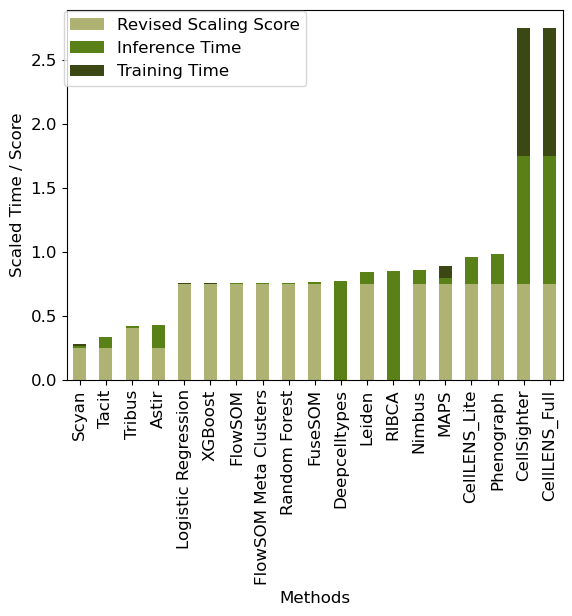

In [58]:
# scale train and inference time to be between 0 and 1 where 0 is fastest and 1 is slowest
inference_thresh = max(scalability_plot_lvl3["inference_time_mean"])
train_thresh = max(scalability_plot_lvl3["train_time_mean"])

scalability_plot_lvl3["train_time_scaled"] = scalability_plot_lvl3["train_time_mean"] / train_thresh
scalability_plot_lvl3["inference_time_scaled"] = scalability_plot_lvl3["inference_time_mean"] / inference_thresh
scalability_plot_lvl3["revised_scaling_score"] = 1 - scalability_plot_lvl3["scaling_score"]

# Calculate total for ordering
scalability_plot_lvl3["total"] = (
    scalability_plot_lvl3["revised_scaling_score"] +
    scalability_plot_lvl3["inference_time_scaled"] +
    scalability_plot_lvl3["train_time_scaled"]
)

# Sort by total (lowest to highest)
scalability_plot_lvl3_sorted = scalability_plot_lvl3.sort_values("total")

colors = [
    "#aeb374",  # green1
    "#598118",  # green2
    "#3b4814",  # green3
]

# plot a stacked barplot with methods in the x axis and train and inference time in the y axis
ax = scalability_plot_lvl3_sorted.plot.bar(
    x="method",
    y=["revised_scaling_score", "inference_time_scaled", "train_time_scaled"],
    stacked=True,
    color=colors
)

# Rename legend labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Revised Scaling Score", "Inference Time", "Training Time"], fontsize=12, bbox_to_anchor=(0.5, 1.02), loc='upper right')

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Methods")
plt.ylabel("Scaled Time / Score")
ax.grid(False)  # Remove grid lines
plt.savefig(os.path.join(output_path, "scalability_plot_lvl3.svg"), format='svg', bbox_inches='tight', dpi=300)


In [59]:

methods = scalability_plot_lvl3_sorted["method"].tolist()
revised_scaling_score = scalability_plot_lvl3_sorted["revised_scaling_score"].fillna(0)
inference_time_scaled = scalability_plot_lvl3_sorted["inference_time_scaled"].fillna(0)
train_time_scaled = scalability_plot_lvl3_sorted["train_time_scaled"].fillna(0)

fig = go.Figure(data=[
    go.Bar(name='Revised Scaling Score', x=methods, y=revised_scaling_score, marker_color='#aeb374'),
    go.Bar(name='Inference Time (scaled)', x=methods, y=inference_time_scaled, marker_color='#598118'),
    go.Bar(name='Train Time (scaled)', x=methods, y=train_time_scaled, marker_color='#3b4814')
])

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Method',
    xaxis_tickangle=-45,
    yaxis_title='Scaled Value',
    title='Scalability Components by Method',
    #legend=dict(x=1.05, y=1, bordercolor="Black", borderwidth=1),
    width=800,
    height=400,
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

fig.write_html(os.path.join(output_path, "scalability_plot.html"))

# save as svg
fig.write_image(os.path.join(output_path, "scalability_plot.svg"), width=800, height=400, scale=2)